In [25]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

class MNISTDatasetLoader:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.train_images = None
        self.train_labels = None
        self.test_images = None
        self.test_labels = None
    '''
    def load_images(self, file_name):
        """加载图像文件"""
        file_path = os.path.join(self.dataset_path, file_name)
        with open(file_path, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            images = np.fromfile(file, dtype=np.uint8).reshape(size, rows, cols)
        return images'''

    def load_images(self, file_name):
        """加载图像文件并将每个图像重塑为一维向量"""
        file_path = os.path.join(self.dataset_path, file_name)
        with open(file_path, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            # 确保每张图像被压平为一个长向量
            images = np.fromfile(file, dtype=np.uint8).reshape(size, rows * cols)
        return images

    def load_labels(self, file_name):
        """加载标签文件"""
        file_path = os.path.join(self.dataset_path, file_name)
        with open(file_path, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            labels = np.fromfile(file, dtype=np.uint8)
        return labels

    def load_dataset(self):
        """加载训练集和测试集数据"""
        self.train_images = self.load_images('train-images-idx3-ubyte')
        self.train_labels = self.load_labels('train-labels-idx1-ubyte')
        self.test_images = self.load_images('t10k-images-idx3-ubyte')
        self.test_labels = self.load_labels('t10k-labels-idx1-ubyte')

    def visualize_sample(self, dataset='train', idx=0):
        """可视化样本数据"""
        if dataset == 'train':
            image = self.train_images[idx]
            label = self.train_labels[idx]
        elif dataset == 'test':
            image = self.test_images[idx]
            label = self.test_labels[idx]
        else:
            raise ValueError("Invalid dataset. Choose 'train' or 'test'.")

        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.show()

# 假设 train.py 与 dataset 文件夹在同一目录下
dataset_path = './dataset'  # 路径根据实际情况修改

# 创建 MNISTDatasetLoader 实例
loader = MNISTDatasetLoader(dataset_path)

# 加载数据集
loader.load_dataset()

# 可视化第一个训练样本
#loader.visualize_sample(dataset='train', idx=0)
# 可视化第一个测试样本
#loader.visualize_sample(dataset='test', idx=0)

data_x = loader.train_images
data_y1 = loader.train_labels
test_x = loader.test_images
test_y1 = loader.test_labels



In [26]:
data_y = np.zeros((data_y1.size, 10))
test_y = np.zeros((test_y1.size, 10))
# 在对应的位置上设置1
data_y[np.arange(data_y1.size), data_y1] = 1
test_y[np.arange(test_y1.size), test_y1] = 1

In [27]:
# 设置随机种子以保证结果可复现
np.random.seed(2024)

# 获取所有数据的索引
indices = np.arange(data_x.shape[0])
print(indices)
# 打乱索引
np.random.shuffle(indices)
print(indices)
# 分割索引以得到训练集和验证集的索引
train_indices = indices[:50000]
valid_indices = indices[50000:]
print(indices)

# 使用这些索引来创建训练集和验证集
train_x = data_x[train_indices]
train_y = data_y[train_indices]
valid_x = data_x[valid_indices]
valid_y = data_y[valid_indices]

# 输出训练集和验证集的大小以确认划分正确
print("训练集数据的shape:", train_x.shape)  # 预期是 (50000, 784)
print("训练集标签的shape:", train_y.shape)  # 预期是 (50000, 10)
print("验证集数据的shape:", valid_x.shape)  # 预期是 (10000, 784)
print("验证集标签的shape:", valid_y.shape)  # 预期是 (10000, 10)


[    0     1     2 ... 59997 59998 59999]
[50820   673 43267 ... 51808 52730  7816]
[50820   673 43267 ... 51808 52730  7816]
训练集数据的shape: (50000, 784)
训练集标签的shape: (50000, 10)
验证集数据的shape: (10000, 784)
验证集标签的shape: (10000, 10)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


In [29]:
# 将数据转换为torch tensors
train_x_torch = torch.tensor(train_x, dtype=torch.float32)
train_y_torch = torch.tensor(train_y, dtype=torch.float32)
valid_x_torch = torch.tensor(valid_x, dtype=torch.float32)
valid_y_torch = torch.tensor(valid_y, dtype=torch.float32)

# 创建TensorDatasets
train_dataset = TensorDataset(train_x_torch, train_y_torch)
valid_dataset = TensorDataset(valid_x_torch, valid_y_torch)

# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 256),  # 第一层: 784 输入特征, 256 输出特征
            nn.ReLU(),
            nn.Linear(256, 128),  # 第二层: 256 输入特征, 128 输出特征
            nn.Sigmoid(),
            nn.Linear(128, 64),   # 第三层: 128 输入特征, 64 输出特征
            nn.ReLU(),
            nn.Linear(64, 10)     # 输出层: 64 输入特征, 10 个类别
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    model.train()
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, torch.max(y, 1)[1])
        train_loss += loss.item()
        
        # Compute accuracy
        correct += (pred.argmax(1) == torch.max(y, 1)[1]).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    valid_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valid_loss += loss_fn(pred, torch.max(y, 1)[1]).item()
            correct += (pred.argmax(1) == torch.max(y, 1)[1]).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    return valid_loss, correct


Epoch 1
-------------------------------
Loss: 0.624117

Epoch 2
-------------------------------
Loss: 0.614391

Epoch 3
-------------------------------
Loss: 0.630350

Epoch 4
-------------------------------
Loss: 0.623372

Epoch 5
-------------------------------
Loss: 0.645974

Epoch 6
-------------------------------
Loss: 0.607681

Epoch 7
-------------------------------
Loss: 0.611340

Epoch 8
-------------------------------
Loss: 0.578136

Epoch 9
-------------------------------
Loss: 0.593503

Epoch 10
-------------------------------
Loss: 0.595025



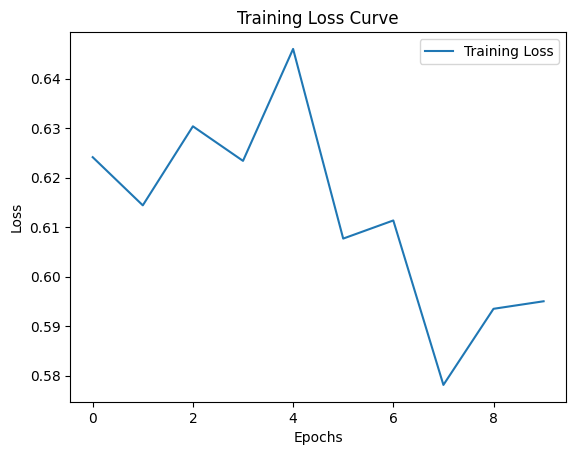

In [33]:
epochs = 10
all_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    current_loss = 0
    for X, y in train_loader:
        pred = model(X)
        current_loss += loss_fn(pred, torch.max(y, 1)[1]).item()
    all_losses.append(current_loss / len(train_loader))
    print(f"Loss: {all_losses[-1]:>7f}\n")

# 绘制损失曲线
plt.figure()
plt.plot(all_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1
-------------------------------
Train Loss: 0.6020, Train Accuracy: 0.78
Valid Loss: 0.6149, Valid Accuracy: 0.76

Epoch 2
-------------------------------
Train Loss: 0.5890, Train Accuracy: 0.78
Valid Loss: 0.5960, Valid Accuracy: 0.77

Epoch 3
-------------------------------
Train Loss: 0.5852, Train Accuracy: 0.79
Valid Loss: 0.5968, Valid Accuracy: 0.79

Epoch 4
-------------------------------
Train Loss: 0.5657, Train Accuracy: 0.79
Valid Loss: 0.5875, Valid Accuracy: 0.78

Epoch 5
-------------------------------
Train Loss: 0.5562, Train Accuracy: 0.80
Valid Loss: 0.5455, Valid Accuracy: 0.80

Epoch 6
-------------------------------
Train Loss: 0.5542, Train Accuracy: 0.80
Valid Loss: 0.5674, Valid Accuracy: 0.79

Epoch 7
-------------------------------
Train Loss: 0.5618, Train Accuracy: 0.79
Valid Loss: 0.5730, Valid Accuracy: 0.78

Epoch 8
-------------------------------
Train Loss: 0.5560, Train Accuracy: 0.79
Valid Loss: 0.5808, Valid Accuracy: 0.77

Epoch 9
--------

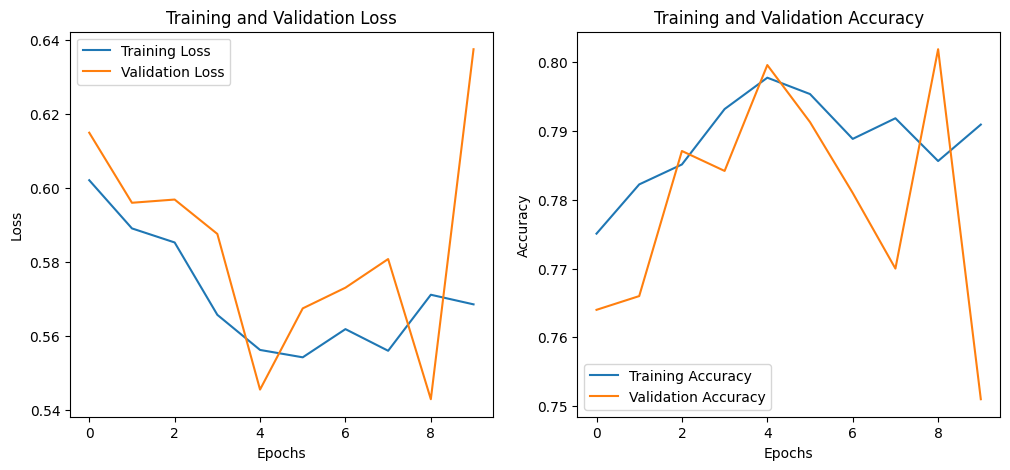

In [34]:
epochs = 10
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer)
    valid_loss, valid_accuracy = validate(valid_loader, model, loss_fn)

    # Append training and validation results
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}\n")

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
